## Table of Contents
* [Introduction](#introduction)
* [Setting Up](#setting-up)
* [Step 0: Problem Statement](#first-bullet)
* [Step 1: Data Exploration, Visualization and Pre-Processing](#second-bullet)
* [Step 2: Feature Engineering](#third-bullet)
* [Step 3: Model Training](#fourth-bullet)
* [Step 4: Prediction](#fifth-bullet)
* [Step 5: Evaluation](#sixth-bullet)
* [Conclusion](#conclusion)

------
# Setting Up <a id='#setting-up'>

- Download requirements.txt from the repository

------
# Step 0: Problem Statement<a id='#first-bullet'>
Predicting the change of 4 output variables according to a step change in 4 input variables.

In [79]:
## Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import confusion_matrix



------
# Step 1: Data Exploration, Visualization and Pre-Processing <a id='#second-bullet'>

In [80]:
# Import data into dataframe
df = pd.read_csv("column_data.csv")
df.dropna(inplace=True)

# Isolate output variables from adjusted variables and store in a separate dataframe
df_output = df.drop(columns=['Time','Feed Flow', 'Feed Composition', 'Reflux Ratio', 'Vapor Flow Rate'])
df_mv = df.drop(columns=['Time', 'Overhead MeOH Composition', 'Bottom Flow Rate', 'Bottom MeOH Composition', 'Overhead Flow Rate'])

In [81]:
# Check top entries of output dataframe
df_output.head()

,Overhead Flow Rate,Overhead MeOH Composition,Bottom Flow Rate,Bottom MeOH Composition
0,0.012517,0.850818,0.011816,0.148973
1,0.012743,0.851284,0.012208,0.150771
2,0.012381,0.849905,0.012168,0.148152
3,0.012620,0.853034,0.012766,0.149025
4,0.012499,0.854668,0.012240,0.150449


In [82]:
# Check top entries of manipulated dataframe
df_mv.head()

,Feed Flow,Feed Composition,Vapor Flow Rate,Reflux Ratio
0,0.025,0.5,0.033,1.75
1,0.025,0.5,0.033,1.75
2,0.025,0.5,0.033,1.75
3,0.025,0.5,0.033,1.75
4,0.025,0.5,0.033,1.75


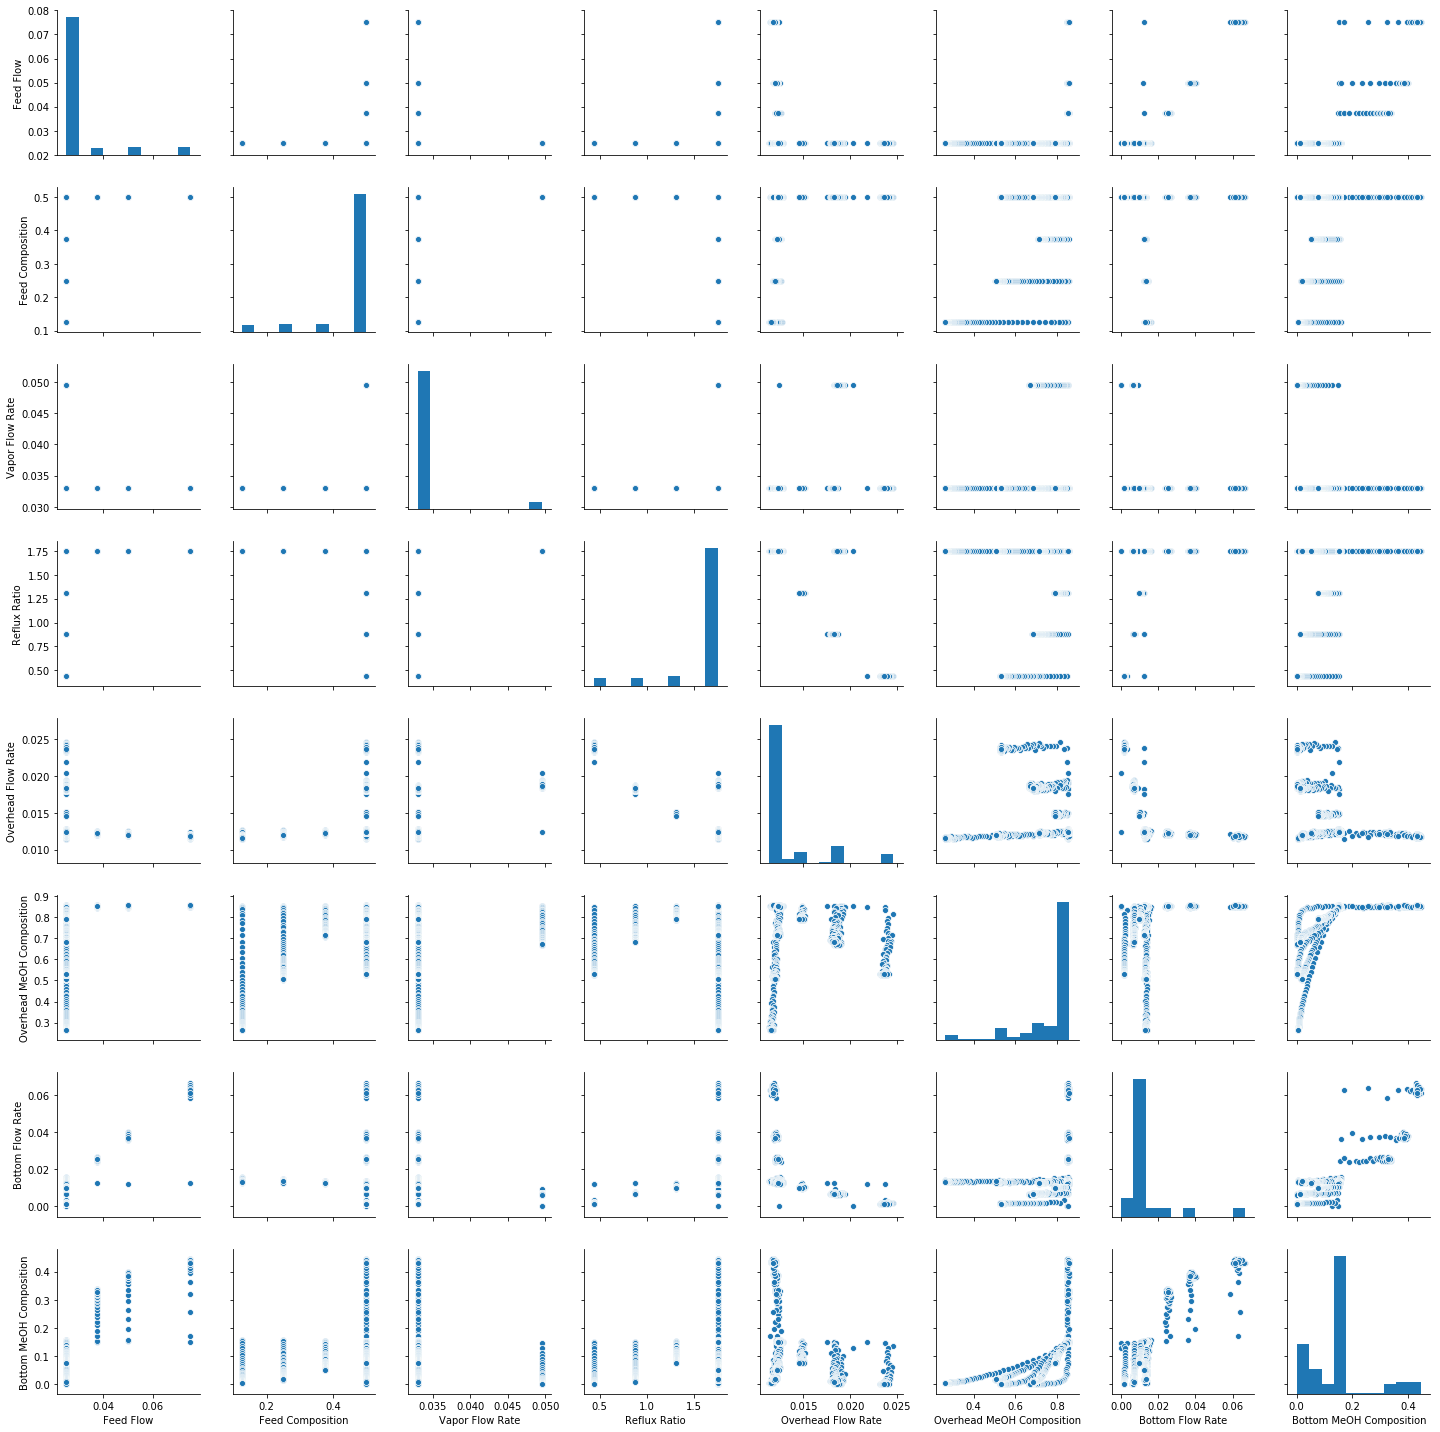

In [83]:
# Explore visualization of both output and manipulated variables
df_visualize = pd.concat([df_mv, df_output], axis=1, sort=False)
sns.pairplot(df_visualize, palette='husl')

In [84]:
# Create 4 dataframes for each output variable
df_ofr = df_output['Overhead Flow Rate'].to_frame()
df_fc = df_output['Overhead MeOH Composition'].to_frame()
df_vfr = df_output['Bottom Flow Rate'].to_frame()
df_rr = df_output['Bottom MeOH Composition'].to_frame()

# Step 2: Feature Engineering <a id='#third-bullet'>

In [85]:
# Step change is induced in manipulated variable and each can be treated as a step change. 
# Encode each of the manipulated variables with LabelEncoder.
col_ff = df_mv.loc[:, 'Feed Flow']
col_fc = df_mv.loc[:, 'Feed Composition']
col_vfr = df_mv.loc[:, 'Vapor Flow Rate']
col_rr = df_mv.loc[:, 'Reflux Ratio']

In [86]:
# Instantiate LabelEncoder
le_1 = LabelEncoder()
le_2 = LabelEncoder()
le_3 = LabelEncoder()
le_4 = LabelEncoder()

In [87]:
# Fit data accordingly
le_1.fit(col_ff)
le_2.fit(col_fc)
le_3.fit(col_vfr)
le_4.fit(col_rr)

LabelEncoder()

In [88]:
# Transform and store encoded data
col_ff_transform = le_1.transform(col_ff)
col_fc_transform = le_2.transform(col_fc)
col_vfr_transform = le_3.transform(col_vfr)
col_rr_transform = le_4.transform(col_rr)

In [63]:
# Create new encoded dataframe
columns_new = ['ff','fc','vfr','rr']
df_mv_encoded = pd.DataFrame({'ff':col_ff_transform[:],
                              'fc':col_fc_transform[:], 
                              'vfr':col_vfr_transform[:],
                              'rr':col_ff_transform[:]})

df_mv_encoded.head()

,ff,fc,vfr,rr
0,0,3,0,0
1,0,3,0,0
2,0,3,0,0
3,0,3,0,0
4,0,3,0,0


In [64]:
# Create 4 new dataframes with output variables. Leave out for now
# df_mvov_ofr = pd.concat([df_mv_encoded, df_ofr], axis=1, sort=False)
# df_mvov_fc = pd.concat([df_mv_encoded, df_fc], axis=1, sort=False)
# df_mvov_vfr = pd.concat([df_mv_encoded, df_vfr], axis=1, sort=False)
# df_mvov_rr = pd.concat([df_mv_encoded, df_rr], axis=1, sort=False)

In [65]:
## Check dataframes. Comment out accordingly
# df_mvov_ofr.head()
# df_mvov_fc.head()
# df_mvov_vfr.head()
# df_mvov_rr.head()

In [66]:
# Conduct test split for training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_mv_encoded, df_ofr)

In [67]:
# Scale dataframe
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [68]:
# Use PCA but keep dimensions constant. Check cumulative variance ratio plot
pca4 = PCA(n_components=4)
X_train_pca4 = pca4.fit_transform(X_train_scaled)
vr = [v*100 for v in pca4.explained_variance_ratio_]

In [69]:
# Double check if transformation has been done correctly
if sum(vr) - 100 < 1e-3:
    print("\n Variance ratio OK!\n")


 Variance ratio OK!



Text(0,0.5,'Cumulative Variance Ratio')

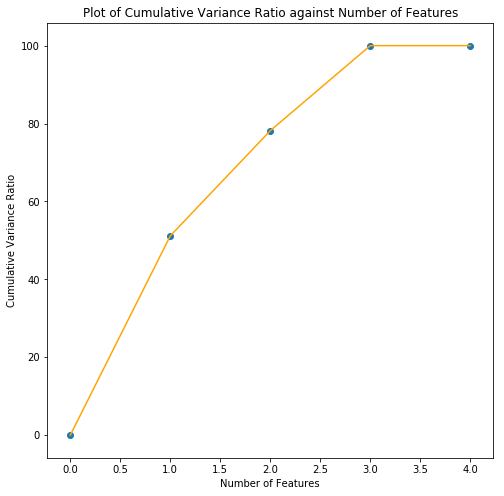

In [70]:
# Plot Cumulative Variance Ratio against Number of Features
cv = [sum(pca4.explained_variance_ratio_[:i])*100 for i in range(len(pca4.explained_variance_ratio_)+1)]
f, ax1 = plt.subplots(figsize=(8,8))
ax1.plot(range(len(cv)), cv, color='orange')
ax1.scatter(range(len(cv)), cv)
ax1.set_title('Plot of Cumulative Variance Ratio against Number of Features')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Cumulative Variance Ratio')

# Set boundaries on the plot if necessary, but makes it difficult to see.
# ax.set_xbound(0,4)
# ax.set_ybound(0,100)

------
# Step 3: Model Training <a id='#third-bullet'>

In [71]:
# Create and train model based on data
regressor = SGDRegressor(max_iter = 1000, random_state=10, verbose=True)
regressor.fit(X_train, y_train)

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-- Epoch 1
Norm: 0.00, NNZs: 4, Bias: 0.003389, T: 1491, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 4, Bias: 0.004470, T: 2982, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 4, Bias: 0.005353, T: 4473, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 4, Bias: 0.006048, T: 5964, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 4, Bias: 0.006585, T: 7455, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 4, Bias: 0.007064, T: 8946, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 4, Bias: 0.007478, T: 10437, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 4, Bias: 0.007848, T: 11928, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 4, Bias: 0.008159, T: 13419, Avg. loss: 0.000004
Total training time: 0.0

Norm: 0.01, NNZs: 4, Bias: 0.011465, T: 530796, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 357
Norm: 0.00, NNZs: 4, Bias: 0.011451, T: 532287, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 358
Norm: 0.01, NNZs: 4, Bias: 0.011465, T: 533778, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 359
Norm: 0.01, NNZs: 4, Bias: 0.011465, T: 535269, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 360
Norm: 0.01, NNZs: 4, Bias: 0.011461, T: 536760, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 361
Norm: 0.01, NNZs: 4, Bias: 0.011453, T: 538251, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 362
Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 539742, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 363
Norm: 0.00, NNZs: 4, Bias: 0.011451, T: 541233, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 364
Norm: 0.01, NNZs: 4, Bias: 0.011459, T: 542724, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011456, T: 870744, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 585
Norm: 0.01, NNZs: 4, Bias: 0.011463, T: 872235, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 586
Norm: 0.01, NNZs: 4, Bias: 0.011458, T: 873726, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 587
Norm: 0.01, NNZs: 4, Bias: 0.011457, T: 875217, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 588
Norm: 0.01, NNZs: 4, Bias: 0.011462, T: 876708, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 589
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 878199, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 590
Norm: 0.01, NNZs: 4, Bias: 0.011453, T: 879690, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 591
Norm: 0.00, NNZs: 4, Bias: 0.011447, T: 881181, Avg. loss: 0.000003
Total training time: 0.38 seconds.
-- Epoch 592
Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 882672, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011459, T: 1209201, Avg. loss: 0.000003
Total training time: 0.56 seconds.
-- Epoch 812
Norm: 0.01, NNZs: 4, Bias: 0.011462, T: 1210692, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 813
Norm: 0.01, NNZs: 4, Bias: 0.011454, T: 1212183, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 814
Norm: 0.01, NNZs: 4, Bias: 0.011461, T: 1213674, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 815
Norm: 0.01, NNZs: 4, Bias: 0.011454, T: 1215165, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 816
Norm: 0.01, NNZs: 4, Bias: 0.011462, T: 1216656, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 817
Norm: 0.01, NNZs: 4, Bias: 0.011466, T: 1218147, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 818
Norm: 0.01, NNZs: 4, Bias: 0.011453, T: 1219638, Avg. loss: 0.000003
Total training time: 0.57 seconds.
-- Epoch 819
Norm: 0.01, NNZs: 4, Bias: 0.011456, T: 1221129, Avg. loss: 0.00

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=10, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [72]:
# Check weights and biases
print(regressor.coef_)
print(regressor.intercept_)

[-0.00037542  0.00073982  0.00491722 -0.00037542]
[0.01145097]


In [73]:
# Plot learning curve
sample_size, train_score, test_score = learning_curve(regressor, X_train, y_train, verbose=True, random_state=10, cv=3)

[learning_curve] Training set sizes: [ 99 323 546 770 994]
-- Epoch 1
Norm: 0.00, NNZs: 4, Bias: 0.001731, T: 99, Avg. loss: 0.000016
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 4, Bias: 0.001964, T: 198, Avg. loss: 0.000008
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 4, Bias: 0.002149, T: 297, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 4, Bias: 0.002311, T: 396, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 4, Bias: 0.002474, T: 495, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 4, Bias: 0.002625, T: 594, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 4, Bias: 0.002753, T: 693, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 4, Bias: 0.002873, T: 792, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 4, Bias: 0.002993, T: 891

-- Epoch 122
Norm: 0.00, NNZs: 4, Bias: 0.008232, T: 12078, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 123
Norm: 0.00, NNZs: 4, Bias: 0.008253, T: 12177, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 124
Norm: 0.00, NNZs: 4, Bias: 0.008276, T: 12276, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 125
Norm: 0.00, NNZs: 4, Bias: 0.008296, T: 12375, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 126
Norm: 0.00, NNZs: 4, Bias: 0.008313, T: 12474, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 127
Norm: 0.00, NNZs: 4, Bias: 0.008339, T: 12573, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 128
Norm: 0.00, NNZs: 4, Bias: 0.008357, T: 12672, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 129
Norm: 0.00, NNZs: 4, Bias: 0.008379, T: 12771, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 130
Norm: 0.00, NNZs: 4, Bias: 0.008403, T: 12870, Avg. loss: 0.000003


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Total training time: 0.20 seconds.
-- Epoch 289
Norm: 0.00, NNZs: 4, Bias: 0.010261, T: 28611, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 290
Norm: 0.00, NNZs: 4, Bias: 0.010266, T: 28710, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 291
Norm: 0.00, NNZs: 4, Bias: 0.010271, T: 28809, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 292
Norm: 0.00, NNZs: 4, Bias: 0.010272, T: 28908, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 293
Norm: 0.00, NNZs: 4, Bias: 0.010278, T: 29007, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 294
Norm: 0.00, NNZs: 4, Bias: 0.010282, T: 29106, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 295
Norm: 0.00, NNZs: 4, Bias: 0.010290, T: 29205, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 296
Norm: 0.00, NNZs: 4, Bias: 0.010300, T: 29304, Avg. loss: 0.000003
Total training time: 0.20 seconds.
-- Epoch 297
Norm: 0.00, NNZs: 4, Bias: 0.01

-- Epoch 455
Norm: 0.00, NNZs: 4, Bias: 0.010904, T: 45045, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 456
Norm: 0.00, NNZs: 4, Bias: 0.010908, T: 45144, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 457
Norm: 0.00, NNZs: 4, Bias: 0.010913, T: 45243, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 458
Norm: 0.00, NNZs: 4, Bias: 0.010919, T: 45342, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 459
Norm: 0.00, NNZs: 4, Bias: 0.010921, T: 45441, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 460
Norm: 0.00, NNZs: 4, Bias: 0.010926, T: 45540, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 461
Norm: 0.00, NNZs: 4, Bias: 0.010927, T: 45639, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 462
Norm: 0.00, NNZs: 4, Bias: 0.010932, T: 45738, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 463
Norm: 0.00, NNZs: 4, Bias: 0.010932, T: 45837, Avg. loss: 0.000003


Norm: 0.01, NNZs: 4, Bias: 0.011166, T: 61479, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 622
Norm: 0.01, NNZs: 4, Bias: 0.011168, T: 61578, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 623
Norm: 0.01, NNZs: 4, Bias: 0.011171, T: 61677, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 624
Norm: 0.01, NNZs: 4, Bias: 0.011172, T: 61776, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 625
Norm: 0.01, NNZs: 4, Bias: 0.011174, T: 61875, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 626
Norm: 0.01, NNZs: 4, Bias: 0.011179, T: 61974, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 627
Norm: 0.01, NNZs: 4, Bias: 0.011175, T: 62073, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 628
Norm: 0.01, NNZs: 4, Bias: 0.011172, T: 62172, Avg. loss: 0.000003
Total training time: 0.39 seconds.
-- Epoch 629
Norm: 0.01, NNZs: 4, Bias: 0.011173, T: 62271, Avg. loss: 0.000003
Total trainin

Norm: 0.01, NNZs: 4, Bias: 0.011319, T: 89892, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 909
Norm: 0.01, NNZs: 4, Bias: 0.011320, T: 89991, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 910
Norm: 0.01, NNZs: 4, Bias: 0.011320, T: 90090, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 911
Norm: 0.01, NNZs: 4, Bias: 0.011319, T: 90189, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 912
Norm: 0.01, NNZs: 4, Bias: 0.011319, T: 90288, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 913
Norm: 0.01, NNZs: 4, Bias: 0.011323, T: 90387, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 914
Norm: 0.01, NNZs: 4, Bias: 0.011324, T: 90486, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 915
Norm: 0.01, NNZs: 4, Bias: 0.011323, T: 90585, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 916
Norm: 0.01, NNZs: 4, Bias: 0.011325, T: 90684, Avg. loss: 0.000003
Total trainin

-- Epoch 1
Norm: 0.00, NNZs: 4, Bias: 0.002113, T: 323, Avg. loss: 0.000010
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 4, Bias: 0.002522, T: 646, Avg. loss: 0.000007
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 4, Bias: 0.002914, T: 969, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 4, Bias: 0.003223, T: 1292, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 4, Bias: 0.003462, T: 1615, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 4, Bias: 0.003718, T: 1938, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 4, Bias: 0.003982, T: 2261, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 4, Bias: 0.004186, T: 2584, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 4, Bias: 0.004435, T: 2907, Avg. loss: 0.000005
Total training time: 0.00 seco

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Norm: 0.00, NNZs: 4, Bias: 0.011336, T: 92701, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 288
Norm: 0.00, NNZs: 4, Bias: 0.011349, T: 93024, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 289
Norm: 0.00, NNZs: 4, Bias: 0.011349, T: 93347, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 290
Norm: 0.00, NNZs: 4, Bias: 0.011344, T: 93670, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 291
Norm: 0.00, NNZs: 4, Bias: 0.011348, T: 93993, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 292
Norm: 0.00, NNZs: 4, Bias: 0.011355, T: 94316, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 293
Norm: 0.00, NNZs: 4, Bias: 0.011353, T: 94639, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 294
Norm: 0.00, NNZs: 4, Bias: 0.011350, T: 94962, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 295
Norm: 0.00, NNZs: 4, Bias: 0.011339, T: 95285, Avg. loss: 0.000003
Total traini

Norm: 0.00, NNZs: 4, Bias: 0.011391, T: 120156, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 373
Norm: 0.00, NNZs: 4, Bias: 0.011388, T: 120479, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 374
Norm: 0.00, NNZs: 4, Bias: 0.011402, T: 120802, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 375
Norm: 0.00, NNZs: 4, Bias: 0.011393, T: 121125, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 376
Norm: 0.00, NNZs: 4, Bias: 0.011396, T: 121448, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 377
Norm: 0.00, NNZs: 4, Bias: 0.011389, T: 121771, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 378
Norm: 0.00, NNZs: 4, Bias: 0.011398, T: 122094, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 379
Norm: 0.00, NNZs: 4, Bias: 0.011402, T: 122417, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 380
Norm: 0.00, NNZs: 4, Bias: 0.011409, T: 122740, Avg. loss: 0.000003
Tota

-- Epoch 708
Norm: 0.01, NNZs: 4, Bias: 0.011430, T: 228684, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 709
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 229007, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 710
Norm: 0.01, NNZs: 4, Bias: 0.011425, T: 229330, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 711
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 229653, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 712
Norm: 0.01, NNZs: 4, Bias: 0.011421, T: 229976, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 713
Norm: 0.01, NNZs: 4, Bias: 0.011426, T: 230299, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 714
Norm: 0.01, NNZs: 4, Bias: 0.011427, T: 230622, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 715
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 230945, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 716
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 231268, Avg. loss: 

Total training time: 0.43 seconds.
-- Epoch 787
Norm: 0.01, NNZs: 4, Bias: 0.011427, T: 254201, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 788
Norm: 0.01, NNZs: 4, Bias: 0.011427, T: 254524, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 789
Norm: 0.01, NNZs: 4, Bias: 0.011437, T: 254847, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 790
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 255170, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 791
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 255493, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 792
Norm: 0.01, NNZs: 4, Bias: 0.011432, T: 255816, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 793
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 256139, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 794
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 256462, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 795
Norm: 0.01, NNZs: 4, Bia

-- Epoch 116
Norm: 0.00, NNZs: 4, Bias: 0.011156, T: 63336, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 117
Norm: 0.00, NNZs: 4, Bias: 0.011162, T: 63882, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 118
Norm: 0.00, NNZs: 4, Bias: 0.011144, T: 64428, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 119
Norm: 0.00, NNZs: 4, Bias: 0.011176, T: 64974, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 120
Norm: 0.00, NNZs: 4, Bias: 0.011190, T: 65520, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 121
Norm: 0.00, NNZs: 4, Bias: 0.011173, T: 66066, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 122
Norm: 0.00, NNZs: 4, Bias: 0.011187, T: 66612, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 123
Norm: 0.00, NNZs: 4, Bias: 0.011194, T: 67158, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 124
Norm: 0.00, NNZs: 4, Bias: 0.011204, T: 67704, Avg. loss: 0.000003


c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.00, NNZs: 4, Bias: 0.011323, T: 84630, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 156
Norm: 0.00, NNZs: 4, Bias: 0.011327, T: 85176, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 157
Norm: 0.00, NNZs: 4, Bias: 0.011329, T: 85722, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 158
Norm: 0.00, NNZs: 4, Bias: 0.011327, T: 86268, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 159
Norm: 0.00, NNZs: 4, Bias: 0.011325, T: 86814, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 160
Norm: 0.00, NNZs: 4, Bias: 0.011338, T: 87360, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 161
Norm: 0.00, NNZs: 4, Bias: 0.011332, T: 87906, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 162
Norm: 0.00, NNZs: 4, Bias: 0.011323, T: 88452, Avg. loss: 0.000003
Total training time: 0.08 seconds.
-- Epoch 163
Norm: 0.00, NNZs: 4, Bias: 0.011337, T: 88998, Avg. loss: 0.000003
Total trainin

Norm: 0.01, NNZs: 4, Bias: 0.011455, T: 246792, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 453
Norm: 0.01, NNZs: 4, Bias: 0.011446, T: 247338, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 454
Norm: 0.01, NNZs: 4, Bias: 0.011453, T: 247884, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 455
Norm: 0.01, NNZs: 4, Bias: 0.011452, T: 248430, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 456
Norm: 0.01, NNZs: 4, Bias: 0.011457, T: 248976, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 457
Norm: 0.01, NNZs: 4, Bias: 0.011458, T: 249522, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 458
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 250068, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 459
Norm: 0.01, NNZs: 4, Bias: 0.011456, T: 250614, Avg. loss: 0.000003
Total training time: 0.24 seconds.
-- Epoch 460
Norm: 0.01, NNZs: 4, Bias: 0.011451, T: 251160, Avg. loss: 0.000003
Tota

Total training time: 0.26 seconds.
-- Epoch 619
Norm: 0.01, NNZs: 4, Bias: 0.011451, T: 337974, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 620
Norm: 0.01, NNZs: 4, Bias: 0.011458, T: 338520, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 621
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 339066, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 622
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 339612, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 623
Norm: 0.01, NNZs: 4, Bias: 0.011442, T: 340158, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 624
Norm: 0.01, NNZs: 4, Bias: 0.011454, T: 340704, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 625
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 341250, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 626
Norm: 0.01, NNZs: 4, Bias: 0.011455, T: 341796, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 627
Norm: 0.01, NNZs: 4, Bia

-- Epoch 901
Norm: 0.01, NNZs: 4, Bias: 0.011457, T: 491946, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 902
Norm: 0.01, NNZs: 4, Bias: 0.011457, T: 492492, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 903
Norm: 0.01, NNZs: 4, Bias: 0.011458, T: 493038, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 904
Norm: 0.01, NNZs: 4, Bias: 0.011451, T: 493584, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 905
Norm: 0.01, NNZs: 4, Bias: 0.011459, T: 494130, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 906
Norm: 0.01, NNZs: 4, Bias: 0.011457, T: 494676, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 907
Norm: 0.01, NNZs: 4, Bias: 0.011446, T: 495222, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 908
Norm: 0.01, NNZs: 4, Bias: 0.011449, T: 495768, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 909
Norm: 0.01, NNZs: 4, Bias: 0.011459, T: 496314, Avg. loss: 

-- Epoch 1
Norm: 0.00, NNZs: 4, Bias: 0.002716, T: 770, Avg. loss: 0.000008
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 4, Bias: 0.003525, T: 1540, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 4, Bias: 0.004103, T: 2310, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 4, Bias: 0.004627, T: 3080, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 4, Bias: 0.005099, T: 3850, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 4, Bias: 0.005476, T: 4620, Avg. loss: 0.000005
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 4, Bias: 0.005897, T: 5390, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 4, Bias: 0.006244, T: 6160, Avg. loss: 0.000004
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 4, Bias: 0.006491, T: 6930, Avg. loss: 0.000004
Total training time: 0.00 se

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.01, NNZs: 4, Bias: 0.011506, T: 195580, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 255
Norm: 0.01, NNZs: 4, Bias: 0.011505, T: 196350, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 256
Norm: 0.01, NNZs: 4, Bias: 0.011497, T: 197120, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 257
Norm: 0.01, NNZs: 4, Bias: 0.011500, T: 197890, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 258
Norm: 0.01, NNZs: 4, Bias: 0.011484, T: 198660, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 259
Norm: 0.01, NNZs: 4, Bias: 0.011494, T: 199430, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 260
Norm: 0.01, NNZs: 4, Bias: 0.011499, T: 200200, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 261
Norm: 0.01, NNZs: 4, Bias: 0.011497, T: 200970, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 262
Norm: 0.01, NNZs: 4, Bias: 0.011501, T: 201740, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011489, T: 290290, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 378
Norm: 0.01, NNZs: 4, Bias: 0.011514, T: 291060, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 379
Norm: 0.01, NNZs: 4, Bias: 0.011486, T: 291830, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 380
Norm: 0.01, NNZs: 4, Bias: 0.011494, T: 292600, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 381
Norm: 0.01, NNZs: 4, Bias: 0.011507, T: 293370, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 382
Norm: 0.01, NNZs: 4, Bias: 0.011485, T: 294140, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 383
Norm: 0.01, NNZs: 4, Bias: 0.011484, T: 294910, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 384
Norm: 0.01, NNZs: 4, Bias: 0.011506, T: 295680, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 385
Norm: 0.01, NNZs: 4, Bias: 0.011501, T: 296450, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011499, T: 475090, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 618
Norm: 0.01, NNZs: 4, Bias: 0.011497, T: 475860, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 619
Norm: 0.01, NNZs: 4, Bias: 0.011495, T: 476630, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 620
Norm: 0.01, NNZs: 4, Bias: 0.011501, T: 477400, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 621
Norm: 0.01, NNZs: 4, Bias: 0.011499, T: 478170, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 622
Norm: 0.01, NNZs: 4, Bias: 0.011495, T: 478940, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 623
Norm: 0.01, NNZs: 4, Bias: 0.011507, T: 479710, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 624
Norm: 0.01, NNZs: 4, Bias: 0.011499, T: 480480, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 625
Norm: 0.01, NNZs: 4, Bias: 0.011504, T: 481250, Avg. loss: 0.000003
Tota

-- Epoch 784
Norm: 0.01, NNZs: 4, Bias: 0.011502, T: 603680, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 785
Norm: 0.01, NNZs: 4, Bias: 0.011495, T: 604450, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 786
Norm: 0.01, NNZs: 4, Bias: 0.011503, T: 605220, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 787
Norm: 0.01, NNZs: 4, Bias: 0.011497, T: 605990, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 788
Norm: 0.01, NNZs: 4, Bias: 0.011482, T: 606760, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 789
Norm: 0.01, NNZs: 4, Bias: 0.011509, T: 607530, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 790
Norm: 0.01, NNZs: 4, Bias: 0.011501, T: 608300, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 791
Norm: 0.01, NNZs: 4, Bias: 0.011491, T: 609070, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 792
Norm: 0.01, NNZs: 4, Bias: 0.011491, T: 609840, Avg. loss: 

Norm: 0.00, NNZs: 4, Bias: 0.009994, T: 25844, Avg. loss: 0.000003
Total training time: 0.00 seconds.
-- Epoch 27
Norm: 0.00, NNZs: 4, Bias: 0.010060, T: 26838, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 28
Norm: 0.00, NNZs: 4, Bias: 0.010128, T: 27832, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 29
Norm: 0.00, NNZs: 4, Bias: 0.010218, T: 28826, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 30
Norm: 0.00, NNZs: 4, Bias: 0.010275, T: 29820, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 31
Norm: 0.00, NNZs: 4, Bias: 0.010344, T: 30814, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 32
Norm: 0.00, NNZs: 4, Bias: 0.010397, T: 31808, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 33
Norm: 0.00, NNZs: 4, Bias: 0.010469, T: 32802, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 34
Norm: 0.00, NNZs: 4, Bias: 0.010509, T: 33796, Avg. loss: 0.000003
Total training time: 

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Total training time: 0.10 seconds.
-- Epoch 224
Norm: 0.01, NNZs: 4, Bias: 0.011512, T: 222656, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 225
Norm: 0.01, NNZs: 4, Bias: 0.011513, T: 223650, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 226
Norm: 0.01, NNZs: 4, Bias: 0.011522, T: 224644, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 227
Norm: 0.01, NNZs: 4, Bias: 0.011531, T: 225638, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 228
Norm: 0.01, NNZs: 4, Bias: 0.011509, T: 226632, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 229
Norm: 0.01, NNZs: 4, Bias: 0.011518, T: 227626, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 230
Norm: 0.01, NNZs: 4, Bias: 0.011514, T: 228620, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 231
Norm: 0.01, NNZs: 4, Bias: 0.011526, T: 229614, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 232
Norm: 0.01, NNZs: 4, Bi

Norm: 0.01, NNZs: 4, Bias: 0.011520, T: 441336, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 445
Norm: 0.01, NNZs: 4, Bias: 0.011515, T: 442330, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 446
Norm: 0.01, NNZs: 4, Bias: 0.011517, T: 443324, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 447
Norm: 0.01, NNZs: 4, Bias: 0.011516, T: 444318, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 448
Norm: 0.01, NNZs: 4, Bias: 0.011514, T: 445312, Avg. loss: 0.000003
Total training time: 0.19 seconds.
-- Epoch 449
Norm: 0.01, NNZs: 4, Bias: 0.011519, T: 446306, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 450
Norm: 0.01, NNZs: 4, Bias: 0.011518, T: 447300, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 451
Norm: 0.01, NNZs: 4, Bias: 0.011527, T: 448294, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 452
Norm: 0.01, NNZs: 4, Bias: 0.011527, T: 449288, Avg. loss: 0.000003
Tota

-- Epoch 616
Norm: 0.01, NNZs: 4, Bias: 0.011508, T: 612304, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 617
Norm: 0.01, NNZs: 4, Bias: 0.011525, T: 613298, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 618
Norm: 0.01, NNZs: 4, Bias: 0.011526, T: 614292, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 619
Norm: 0.01, NNZs: 4, Bias: 0.011509, T: 615286, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 620
Norm: 0.01, NNZs: 4, Bias: 0.011523, T: 616280, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 621
Norm: 0.01, NNZs: 4, Bias: 0.011527, T: 617274, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 622
Norm: 0.01, NNZs: 4, Bias: 0.011520, T: 618268, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 623
Norm: 0.01, NNZs: 4, Bias: 0.011510, T: 619262, Avg. loss: 0.000003
Total training time: 0.33 seconds.
-- Epoch 624
Norm: 0.01, NNZs: 4, Bias: 0.011521, T: 620256, Avg. loss: 

Total training time: 0.41 seconds.
-- Epoch 783
Norm: 0.01, NNZs: 4, Bias: 0.011513, T: 778302, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 784
Norm: 0.01, NNZs: 4, Bias: 0.011510, T: 779296, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 785
Norm: 0.01, NNZs: 4, Bias: 0.011523, T: 780290, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 786
Norm: 0.01, NNZs: 4, Bias: 0.011518, T: 781284, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 787
Norm: 0.01, NNZs: 4, Bias: 0.011509, T: 782278, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 788
Norm: 0.01, NNZs: 4, Bias: 0.011523, T: 783272, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 789
Norm: 0.01, NNZs: 4, Bias: 0.011533, T: 784266, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 790
Norm: 0.01, NNZs: 4, Bias: 0.011520, T: 785260, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 791
Norm: 0.01, NNZs: 4, Bia

Norm: 0.01, NNZs: 4, Bias: 0.011524, T: 989030, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 996
Norm: 0.01, NNZs: 4, Bias: 0.011527, T: 990024, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 997
Norm: 0.01, NNZs: 4, Bias: 0.011528, T: 991018, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 998
Norm: 0.01, NNZs: 4, Bias: 0.011521, T: 992012, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 999
Norm: 0.01, NNZs: 4, Bias: 0.011521, T: 993006, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 1000
Norm: 0.01, NNZs: 4, Bias: 0.011520, T: 994000, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 4, Bias: 0.001609, T: 99, Avg. loss: 0.000013
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 4, Bias: 0.001758, T: 198, Avg. loss: 0.000006
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 4, Bias: 0.001852, T: 297, Avg. loss: 0.000005
Total training time

Norm: 0.00, NNZs: 4, Bias: 0.008457, T: 23166, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 235
Norm: 0.00, NNZs: 4, Bias: 0.008463, T: 23265, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 236
Norm: 0.00, NNZs: 4, Bias: 0.008477, T: 23364, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 237
Norm: 0.00, NNZs: 4, Bias: 0.008490, T: 23463, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 238
Norm: 0.00, NNZs: 4, Bias: 0.008504, T: 23562, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 239
Norm: 0.00, NNZs: 4, Bias: 0.008513, T: 23661, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 240
Norm: 0.00, NNZs: 4, Bias: 0.008523, T: 23760, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 241
Norm: 0.00, NNZs: 4, Bias: 0.008538, T: 23859, Avg. loss: 0.000002
Total training time: 0.09 seconds.
-- Epoch 242
Norm: 0.00, NNZs: 4, Bias: 0.008547, T: 23958, Avg. loss: 0.000002
Total trainin

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.00, NNZs: 4, Bias: 0.010067, T: 44352, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 449
Norm: 0.00, NNZs: 4, Bias: 0.010071, T: 44451, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 450
Norm: 0.00, NNZs: 4, Bias: 0.010075, T: 44550, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 451
Norm: 0.00, NNZs: 4, Bias: 0.010075, T: 44649, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 452
Norm: 0.00, NNZs: 4, Bias: 0.010080, T: 44748, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 453
Norm: 0.00, NNZs: 4, Bias: 0.010085, T: 44847, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 454
Norm: 0.00, NNZs: 4, Bias: 0.010087, T: 44946, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 455
Norm: 0.00, NNZs: 4, Bias: 0.010092, T: 45045, Avg. loss: 0.000002
Total training time: 0.24 seconds.
-- Epoch 456
Norm: 0.00, NNZs: 4, Bias: 0.010097, T: 45144, Avg. loss: 0.000002
Total trainin

Total training time: 0.26 seconds.
-- Epoch 615
Norm: 0.01, NNZs: 4, Bias: 0.010645, T: 60885, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 616
Norm: 0.01, NNZs: 4, Bias: 0.010648, T: 60984, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 617
Norm: 0.01, NNZs: 4, Bias: 0.010651, T: 61083, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 618
Norm: 0.01, NNZs: 4, Bias: 0.010654, T: 61182, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 619
Norm: 0.01, NNZs: 4, Bias: 0.010657, T: 61281, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 620
Norm: 0.01, NNZs: 4, Bias: 0.010658, T: 61380, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 621
Norm: 0.01, NNZs: 4, Bias: 0.010663, T: 61479, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 622
Norm: 0.01, NNZs: 4, Bias: 0.010668, T: 61578, Avg. loss: 0.000002
Total training time: 0.32 seconds.
-- Epoch 623
Norm: 0.01, NNZs: 4, Bias: 0.010

Norm: 0.01, NNZs: 4, Bias: 0.011155, T: 91971, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 930
Norm: 0.01, NNZs: 4, Bias: 0.011156, T: 92070, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 931
Norm: 0.01, NNZs: 4, Bias: 0.011154, T: 92169, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 932
Norm: 0.01, NNZs: 4, Bias: 0.011157, T: 92268, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 933
Norm: 0.01, NNZs: 4, Bias: 0.011157, T: 92367, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 934
Norm: 0.01, NNZs: 4, Bias: 0.011158, T: 92466, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 935
Norm: 0.01, NNZs: 4, Bias: 0.011158, T: 92565, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 936
Norm: 0.01, NNZs: 4, Bias: 0.011158, T: 92664, Avg. loss: 0.000002
Total training time: 0.42 seconds.
-- Epoch 937
Norm: 0.01, NNZs: 4, Bias: 0.011161, T: 92763, Avg. loss: 0.000002
Total trainin

-- Epoch 114
Norm: 0.00, NNZs: 4, Bias: 0.010441, T: 36822, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 115
Norm: 0.00, NNZs: 4, Bias: 0.010446, T: 37145, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 116
Norm: 0.00, NNZs: 4, Bias: 0.010467, T: 37468, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 117
Norm: 0.00, NNZs: 4, Bias: 0.010483, T: 37791, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 118
Norm: 0.00, NNZs: 4, Bias: 0.010505, T: 38114, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 119
Norm: 0.00, NNZs: 4, Bias: 0.010512, T: 38437, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 120
Norm: 0.00, NNZs: 4, Bias: 0.010522, T: 38760, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 121
Norm: 0.00, NNZs: 4, Bias: 0.010550, T: 39083, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 122
Norm: 0.00, NNZs: 4, Bias: 0.010562, T: 39406, Avg. loss: 0.000003


c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Total training time: 0.16 seconds.
-- Epoch 281
Norm: 0.00, NNZs: 4, Bias: 0.011309, T: 90763, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 282
Norm: 0.00, NNZs: 4, Bias: 0.011314, T: 91086, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 283
Norm: 0.00, NNZs: 4, Bias: 0.011323, T: 91409, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 284
Norm: 0.00, NNZs: 4, Bias: 0.011321, T: 91732, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 285
Norm: 0.00, NNZs: 4, Bias: 0.011334, T: 92055, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 286
Norm: 0.00, NNZs: 4, Bias: 0.011335, T: 92378, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 287
Norm: 0.00, NNZs: 4, Bias: 0.011331, T: 92701, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 288
Norm: 0.00, NNZs: 4, Bias: 0.011328, T: 93024, Avg. loss: 0.000003
Total training time: 0.16 seconds.
-- Epoch 289
Norm: 0.00, NNZs: 4, Bias: 0.01

Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 166022, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 515
Norm: 0.01, NNZs: 4, Bias: 0.011420, T: 166345, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 516
Norm: 0.01, NNZs: 4, Bias: 0.011419, T: 166668, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 517
Norm: 0.01, NNZs: 4, Bias: 0.011428, T: 166991, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 518
Norm: 0.01, NNZs: 4, Bias: 0.011419, T: 167314, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 519
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 167637, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 520
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 167960, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 521
Norm: 0.01, NNZs: 4, Bias: 0.011428, T: 168283, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 522
Norm: 0.01, NNZs: 4, Bias: 0.011428, T: 168606, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011437, T: 232883, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 722
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 233206, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 723
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 233529, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 724
Norm: 0.01, NNZs: 4, Bias: 0.011432, T: 233852, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 725
Norm: 0.01, NNZs: 4, Bias: 0.011430, T: 234175, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 726
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 234498, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 727
Norm: 0.01, NNZs: 4, Bias: 0.011435, T: 234821, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 728
Norm: 0.01, NNZs: 4, Bias: 0.011427, T: 235144, Avg. loss: 0.000003
Total training time: 0.35 seconds.
-- Epoch 729
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 235467, Avg. loss: 0.000003
Tota

Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 300390, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 931
Norm: 0.01, NNZs: 4, Bias: 0.011430, T: 300713, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 932
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 301036, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 933
Norm: 0.01, NNZs: 4, Bias: 0.011434, T: 301359, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 934
Norm: 0.01, NNZs: 4, Bias: 0.011437, T: 301682, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 935
Norm: 0.01, NNZs: 4, Bias: 0.011433, T: 302005, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 936
Norm: 0.01, NNZs: 4, Bias: 0.011436, T: 302328, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 937
Norm: 0.01, NNZs: 4, Bias: 0.011444, T: 302651, Avg. loss: 0.000003
Total training time: 0.44 seconds.
-- Epoch 938
Norm: 0.01, NNZs: 4, Bias: 0.011435, T: 302974, Avg. loss: 0.000003
Tota

Total training time: 0.07 seconds.
-- Epoch 113
Norm: 0.00, NNZs: 4, Bias: 0.010884, T: 61698, Avg. loss: 0.000004
Total training time: 0.07 seconds.
-- Epoch 114
Norm: 0.00, NNZs: 4, Bias: 0.010886, T: 62244, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 115
Norm: 0.00, NNZs: 4, Bias: 0.010900, T: 62790, Avg. loss: 0.000004
Total training time: 0.07 seconds.
-- Epoch 116
Norm: 0.00, NNZs: 4, Bias: 0.010922, T: 63336, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 117
Norm: 0.00, NNZs: 4, Bias: 0.010940, T: 63882, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 118
Norm: 0.00, NNZs: 4, Bias: 0.010913, T: 64428, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 119
Norm: 0.00, NNZs: 4, Bias: 0.010931, T: 64974, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 120
Norm: 0.00, NNZs: 4, Bias: 0.010954, T: 65520, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 121
Norm: 0.00, NNZs: 4, Bias: 0.010

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Norm: 0.00, NNZs: 4, Bias: 0.011259, T: 152334, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 280
Norm: 0.00, NNZs: 4, Bias: 0.011276, T: 152880, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 281
Norm: 0.00, NNZs: 4, Bias: 0.011267, T: 153426, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 282
Norm: 0.00, NNZs: 4, Bias: 0.011261, T: 153972, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 283
Norm: 0.00, NNZs: 4, Bias: 0.011270, T: 154518, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 284
Norm: 0.00, NNZs: 4, Bias: 0.011272, T: 155064, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 285
Norm: 0.00, NNZs: 4, Bias: 0.011270, T: 155610, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 286
Norm: 0.00, NNZs: 4, Bias: 0.011272, T: 156156, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 287
Norm: 0.00, NNZs: 4, Bias: 0.011282, T: 156702, Avg. loss: 0.000003
Tot

Norm: 0.00, NNZs: 4, Bias: 0.011279, T: 319956, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 587
Norm: 0.00, NNZs: 4, Bias: 0.011285, T: 320502, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 588
Norm: 0.00, NNZs: 4, Bias: 0.011297, T: 321048, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 589
Norm: 0.00, NNZs: 4, Bias: 0.011295, T: 321594, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 590
Norm: 0.00, NNZs: 4, Bias: 0.011285, T: 322140, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 591
Norm: 0.00, NNZs: 4, Bias: 0.011283, T: 322686, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 592
Norm: 0.00, NNZs: 4, Bias: 0.011295, T: 323232, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 593
Norm: 0.00, NNZs: 4, Bias: 0.011287, T: 323778, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 594
Norm: 0.00, NNZs: 4, Bias: 0.011281, T: 324324, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011293, T: 397488, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 729
Norm: 0.00, NNZs: 4, Bias: 0.011285, T: 398034, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 730
Norm: 0.00, NNZs: 4, Bias: 0.011286, T: 398580, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 731
Norm: 0.00, NNZs: 4, Bias: 0.011288, T: 399126, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 732
Norm: 0.00, NNZs: 4, Bias: 0.011281, T: 399672, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 733
Norm: 0.00, NNZs: 4, Bias: 0.011280, T: 400218, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 734
Norm: 0.00, NNZs: 4, Bias: 0.011287, T: 400764, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 735
Norm: 0.00, NNZs: 4, Bias: 0.011293, T: 401310, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 736
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 401856, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011287, T: 515970, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 946
Norm: 0.00, NNZs: 4, Bias: 0.011287, T: 516516, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 947
Norm: 0.00, NNZs: 4, Bias: 0.011292, T: 517062, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 948
Norm: 0.00, NNZs: 4, Bias: 0.011295, T: 517608, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 949
Norm: 0.00, NNZs: 4, Bias: 0.011287, T: 518154, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 950
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 518700, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 951
Norm: 0.00, NNZs: 4, Bias: 0.011290, T: 519246, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 952
Norm: 0.00, NNZs: 4, Bias: 0.011286, T: 519792, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 953
Norm: 0.00, NNZs: 4, Bias: 0.011291, T: 520338, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011054, T: 61600, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 81
Norm: 0.00, NNZs: 4, Bias: 0.011063, T: 62370, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 82
Norm: 0.00, NNZs: 4, Bias: 0.011064, T: 63140, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 83
Norm: 0.00, NNZs: 4, Bias: 0.011086, T: 63910, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 84
Norm: 0.00, NNZs: 4, Bias: 0.011083, T: 64680, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 85
Norm: 0.00, NNZs: 4, Bias: 0.011108, T: 65450, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 86
Norm: 0.00, NNZs: 4, Bias: 0.011114, T: 66220, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 87
Norm: 0.00, NNZs: 4, Bias: 0.011112, T: 66990, Avg. loss: 0.000003
Total training time: 0.01 seconds.
-- Epoch 88
Norm: 0.00, NNZs: 4, Bias: 0.011129, T: 67760, Avg. loss: 0.000003
Total training time: 

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.00, NNZs: 4, Bias: 0.011383, T: 264880, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 345
Norm: 0.00, NNZs: 4, Bias: 0.011397, T: 265650, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 346
Norm: 0.00, NNZs: 4, Bias: 0.011393, T: 266420, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 347
Norm: 0.00, NNZs: 4, Bias: 0.011388, T: 267190, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 348
Norm: 0.00, NNZs: 4, Bias: 0.011393, T: 267960, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 349
Norm: 0.00, NNZs: 4, Bias: 0.011386, T: 268730, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 350
Norm: 0.00, NNZs: 4, Bias: 0.011391, T: 269500, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 351
Norm: 0.00, NNZs: 4, Bias: 0.011412, T: 270270, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 352
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 271040, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011399, T: 341880, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 445
Norm: 0.00, NNZs: 4, Bias: 0.011390, T: 342650, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 446
Norm: 0.00, NNZs: 4, Bias: 0.011390, T: 343420, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 447
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 344190, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 448
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 344960, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 449
Norm: 0.00, NNZs: 4, Bias: 0.011395, T: 345730, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 450
Norm: 0.00, NNZs: 4, Bias: 0.011397, T: 346500, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 451
Norm: 0.00, NNZs: 4, Bias: 0.011375, T: 347270, Avg. loss: 0.000003
Total training time: 0.25 seconds.
-- Epoch 452
Norm: 0.00, NNZs: 4, Bias: 0.011391, T: 348040, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011395, T: 598290, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 778
Norm: 0.00, NNZs: 4, Bias: 0.011388, T: 599060, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 779
Norm: 0.00, NNZs: 4, Bias: 0.011401, T: 599830, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 780
Norm: 0.00, NNZs: 4, Bias: 0.011387, T: 600600, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 781
Norm: 0.00, NNZs: 4, Bias: 0.011382, T: 601370, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 782
Norm: 0.00, NNZs: 4, Bias: 0.011392, T: 602140, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 783
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 602910, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 784
Norm: 0.00, NNZs: 4, Bias: 0.011399, T: 603680, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 785
Norm: 0.00, NNZs: 4, Bias: 0.011400, T: 604450, Avg. loss: 0.000003
Tota

-- Epoch 944
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 726880, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 945
Norm: 0.00, NNZs: 4, Bias: 0.011394, T: 727650, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 946
Norm: 0.00, NNZs: 4, Bias: 0.011382, T: 728420, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 947
Norm: 0.00, NNZs: 4, Bias: 0.011400, T: 729190, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 948
Norm: 0.00, NNZs: 4, Bias: 0.011389, T: 729960, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 949
Norm: 0.00, NNZs: 4, Bias: 0.011390, T: 730730, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 950
Norm: 0.00, NNZs: 4, Bias: 0.011378, T: 731500, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 951
Norm: 0.00, NNZs: 4, Bias: 0.011406, T: 732270, Avg. loss: 0.000003
Total training time: 0.50 seconds.
-- Epoch 952
Norm: 0.00, NNZs: 4, Bias: 0.011387, T: 733040, Avg. loss: 

Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 247506, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 250
Norm: 0.00, NNZs: 4, Bias: 0.011458, T: 248500, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 251
Norm: 0.00, NNZs: 4, Bias: 0.011448, T: 249494, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 252
Norm: 0.00, NNZs: 4, Bias: 0.011454, T: 250488, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 253
Norm: 0.00, NNZs: 4, Bias: 0.011425, T: 251482, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 254
Norm: 0.00, NNZs: 4, Bias: 0.011445, T: 252476, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 255
Norm: 0.00, NNZs: 4, Bias: 0.011449, T: 253470, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 256
Norm: 0.00, NNZs: 4, Bias: 0.011441, T: 254464, Avg. loss: 0.000003
Total training time: 0.10 seconds.
-- Epoch 257
Norm: 0.00, NNZs: 4, Bias: 0.011461, T: 255458, Avg. loss: 0.000003
Tota

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.00, NNZs: 4, Bias: 0.011449, T: 379708, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 383
Norm: 0.00, NNZs: 4, Bias: 0.011451, T: 380702, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 384
Norm: 0.00, NNZs: 4, Bias: 0.011463, T: 381696, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 385
Norm: 0.00, NNZs: 4, Bias: 0.011436, T: 382690, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 386
Norm: 0.00, NNZs: 4, Bias: 0.011455, T: 383684, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 387
Norm: 0.00, NNZs: 4, Bias: 0.011443, T: 384678, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 388
Norm: 0.00, NNZs: 4, Bias: 0.011444, T: 385672, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 389
Norm: 0.00, NNZs: 4, Bias: 0.011458, T: 386666, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 390
Norm: 0.00, NNZs: 4, Bias: 0.011454, T: 387660, Avg. loss: 0.000003
Tota

Total training time: 0.32 seconds.
-- Epoch 610
Norm: 0.00, NNZs: 4, Bias: 0.011439, T: 606340, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 611
Norm: 0.00, NNZs: 4, Bias: 0.011438, T: 607334, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 612
Norm: 0.00, NNZs: 4, Bias: 0.011453, T: 608328, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 613
Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 609322, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 614
Norm: 0.00, NNZs: 4, Bias: 0.011439, T: 610316, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 615
Norm: 0.00, NNZs: 4, Bias: 0.011456, T: 611310, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 616
Norm: 0.00, NNZs: 4, Bias: 0.011438, T: 612304, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 617
Norm: 0.00, NNZs: 4, Bias: 0.011455, T: 613298, Avg. loss: 0.000003
Total training time: 0.32 seconds.
-- Epoch 618
Norm: 0.00, NNZs: 4, Bia

-- Epoch 776
Norm: 0.00, NNZs: 4, Bias: 0.011447, T: 771344, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 777
Norm: 0.00, NNZs: 4, Bias: 0.011436, T: 772338, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 778
Norm: 0.00, NNZs: 4, Bias: 0.011456, T: 773332, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 779
Norm: 0.00, NNZs: 4, Bias: 0.011439, T: 774326, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 780
Norm: 0.00, NNZs: 4, Bias: 0.011451, T: 775320, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 781
Norm: 0.00, NNZs: 4, Bias: 0.011441, T: 776314, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 782
Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 777308, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 783
Norm: 0.00, NNZs: 4, Bias: 0.011444, T: 778302, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 784
Norm: 0.00, NNZs: 4, Bias: 0.011446, T: 779296, Avg. loss: 

Norm: 0.00, NNZs: 4, Bias: 0.003011, T: 1683, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 18
Norm: 0.00, NNZs: 4, Bias: 0.003064, T: 1782, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 19
Norm: 0.00, NNZs: 4, Bias: 0.003115, T: 1881, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 20
Norm: 0.00, NNZs: 4, Bias: 0.003185, T: 1980, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 21
Norm: 0.00, NNZs: 4, Bias: 0.003234, T: 2079, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 22
Norm: 0.00, NNZs: 4, Bias: 0.003285, T: 2178, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 23
Norm: 0.00, NNZs: 4, Bias: 0.003358, T: 2277, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 24
Norm: 0.00, NNZs: 4, Bias: 0.003409, T: 2376, Avg. loss: 0.000004
Total training time: 0.01 seconds.
-- Epoch 25
Norm: 0.00, NNZs: 4, Bias: 0.003458, T: 2475, Avg. loss: 0.000004
Total training time: 0.01 seco

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total training time: 0.11 seconds.
-- Epoch 109
Norm: 0.00, NNZs: 4, Bias: 0.006375, T: 10791, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 110
Norm: 0.00, NNZs: 4, Bias: 0.006402, T: 10890, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 111
Norm: 0.00, NNZs: 4, Bias: 0.006420, T: 10989, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 112
Norm: 0.00, NNZs: 4, Bias: 0.006444, T: 11088, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 113
Norm: 0.00, NNZs: 4, Bias: 0.006466, T: 11187, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 114
Norm: 0.00, NNZs: 4, Bias: 0.006490, T: 11286, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 115
Norm: 0.00, NNZs: 4, Bias: 0.006513, T: 11385, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 116
Norm: 0.00, NNZs: 4, Bias: 0.006532, T: 11484, Avg. loss: 0.000003
Total training time: 0.11 seconds.
-- Epoch 117
Norm: 0.00, NNZs: 4, Bias: 0.006

-- Epoch 275
Norm: 0.00, NNZs: 4, Bias: 0.008893, T: 27225, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 276
Norm: 0.00, NNZs: 4, Bias: 0.008903, T: 27324, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 277
Norm: 0.00, NNZs: 4, Bias: 0.008910, T: 27423, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 278
Norm: 0.00, NNZs: 4, Bias: 0.008919, T: 27522, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 279
Norm: 0.00, NNZs: 4, Bias: 0.008930, T: 27621, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 280
Norm: 0.00, NNZs: 4, Bias: 0.008938, T: 27720, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 281
Norm: 0.00, NNZs: 4, Bias: 0.008947, T: 27819, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 282
Norm: 0.00, NNZs: 4, Bias: 0.008954, T: 27918, Avg. loss: 0.000002
Total training time: 0.23 seconds.
-- Epoch 283
Norm: 0.00, NNZs: 4, Bias: 0.008966, T: 28017, Avg. loss: 0.000002


Total training time: 0.34 seconds.
-- Epoch 442
Norm: 0.00, NNZs: 4, Bias: 0.010033, T: 43758, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 443
Norm: 0.00, NNZs: 4, Bias: 0.010037, T: 43857, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 444
Norm: 0.00, NNZs: 4, Bias: 0.010043, T: 43956, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 445
Norm: 0.00, NNZs: 4, Bias: 0.010049, T: 44055, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 446
Norm: 0.00, NNZs: 4, Bias: 0.010052, T: 44154, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 447
Norm: 0.00, NNZs: 4, Bias: 0.010059, T: 44253, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 448
Norm: 0.00, NNZs: 4, Bias: 0.010067, T: 44352, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 449
Norm: 0.00, NNZs: 4, Bias: 0.010071, T: 44451, Avg. loss: 0.000002
Total training time: 0.34 seconds.
-- Epoch 450
Norm: 0.00, NNZs: 4, Bias: 0.010

-- Epoch 608
Norm: 0.01, NNZs: 4, Bias: 0.010632, T: 60192, Avg. loss: 0.000002
Total training time: 0.46 seconds.
-- Epoch 609
Norm: 0.01, NNZs: 4, Bias: 0.010633, T: 60291, Avg. loss: 0.000002
Total training time: 0.46 seconds.
-- Epoch 610
Norm: 0.01, NNZs: 4, Bias: 0.010634, T: 60390, Avg. loss: 0.000002
Total training time: 0.46 seconds.
-- Epoch 611
Norm: 0.01, NNZs: 4, Bias: 0.010636, T: 60489, Avg. loss: 0.000002
Total training time: 0.46 seconds.
-- Epoch 612
Norm: 0.01, NNZs: 4, Bias: 0.010640, T: 60588, Avg. loss: 0.000002
Total training time: 0.47 seconds.
-- Epoch 613
Norm: 0.01, NNZs: 4, Bias: 0.010641, T: 60687, Avg. loss: 0.000002
Total training time: 0.47 seconds.
-- Epoch 614
Norm: 0.01, NNZs: 4, Bias: 0.010644, T: 60786, Avg. loss: 0.000002
Total training time: 0.47 seconds.
-- Epoch 615
Norm: 0.01, NNZs: 4, Bias: 0.010645, T: 60885, Avg. loss: 0.000002
Total training time: 0.47 seconds.
-- Epoch 616
Norm: 0.01, NNZs: 4, Bias: 0.010648, T: 60984, Avg. loss: 0.000002


Total training time: 0.56 seconds.
-- Epoch 775
Norm: 0.01, NNZs: 4, Bias: 0.010964, T: 76725, Avg. loss: 0.000002
Total training time: 0.56 seconds.
-- Epoch 776
Norm: 0.01, NNZs: 4, Bias: 0.010965, T: 76824, Avg. loss: 0.000002
Total training time: 0.56 seconds.
-- Epoch 777
Norm: 0.01, NNZs: 4, Bias: 0.010969, T: 76923, Avg. loss: 0.000002
Total training time: 0.56 seconds.
-- Epoch 778
Norm: 0.01, NNZs: 4, Bias: 0.010971, T: 77022, Avg. loss: 0.000002
Total training time: 0.57 seconds.
-- Epoch 779
Norm: 0.01, NNZs: 4, Bias: 0.010971, T: 77121, Avg. loss: 0.000002
Total training time: 0.57 seconds.
-- Epoch 780
Norm: 0.01, NNZs: 4, Bias: 0.010973, T: 77220, Avg. loss: 0.000002
Total training time: 0.57 seconds.
-- Epoch 781
Norm: 0.01, NNZs: 4, Bias: 0.010974, T: 77319, Avg. loss: 0.000002
Total training time: 0.57 seconds.
-- Epoch 782
Norm: 0.01, NNZs: 4, Bias: 0.010978, T: 77418, Avg. loss: 0.000002
Total training time: 0.57 seconds.
-- Epoch 783
Norm: 0.01, NNZs: 4, Bias: 0.010

-- Epoch 941
Norm: 0.01, NNZs: 4, Bias: 0.011162, T: 93159, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 942
Norm: 0.01, NNZs: 4, Bias: 0.011165, T: 93258, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 943
Norm: 0.01, NNZs: 4, Bias: 0.011164, T: 93357, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 944
Norm: 0.01, NNZs: 4, Bias: 0.011165, T: 93456, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 945
Norm: 0.01, NNZs: 4, Bias: 0.011171, T: 93555, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 946
Norm: 0.01, NNZs: 4, Bias: 0.011171, T: 93654, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 947
Norm: 0.01, NNZs: 4, Bias: 0.011171, T: 93753, Avg. loss: 0.000002
Total training time: 0.67 seconds.
-- Epoch 948
Norm: 0.01, NNZs: 4, Bias: 0.011173, T: 93852, Avg. loss: 0.000002
Total training time: 0.68 seconds.
-- Epoch 949
Norm: 0.01, NNZs: 4, Bias: 0.011172, T: 93951, Avg. loss: 0.000002


-- Epoch 107
Norm: 0.00, NNZs: 4, Bias: 0.010334, T: 34561, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 108
Norm: 0.00, NNZs: 4, Bias: 0.010342, T: 34884, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 109
Norm: 0.00, NNZs: 4, Bias: 0.010360, T: 35207, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 110
Norm: 0.00, NNZs: 4, Bias: 0.010369, T: 35530, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 111
Norm: 0.00, NNZs: 4, Bias: 0.010394, T: 35853, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 112
Norm: 0.00, NNZs: 4, Bias: 0.010394, T: 36176, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 113
Norm: 0.00, NNZs: 4, Bias: 0.010434, T: 36499, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 114
Norm: 0.00, NNZs: 4, Bias: 0.010441, T: 36822, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 115
Norm: 0.00, NNZs: 4, Bias: 0.010446, T: 37145, Avg. loss: 0.000003


c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total training time: 0.17 seconds.
-- Epoch 274
Norm: 0.00, NNZs: 4, Bias: 0.011310, T: 88502, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 275
Norm: 0.00, NNZs: 4, Bias: 0.011320, T: 88825, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 276
Norm: 0.00, NNZs: 4, Bias: 0.011316, T: 89148, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 277
Norm: 0.00, NNZs: 4, Bias: 0.011315, T: 89471, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 278
Norm: 0.00, NNZs: 4, Bias: 0.011321, T: 89794, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 279
Norm: 0.00, NNZs: 4, Bias: 0.011321, T: 90117, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 280
Norm: 0.00, NNZs: 4, Bias: 0.011313, T: 90440, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 281
Norm: 0.00, NNZs: 4, Bias: 0.011309, T: 90763, Avg. loss: 0.000003
Total training time: 0.17 seconds.
-- Epoch 282
Norm: 0.00, NNZs: 4, Bias: 0.011

Total training time: 0.28 seconds.
-- Epoch 607
Norm: 0.01, NNZs: 4, Bias: 0.011433, T: 196061, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 608
Norm: 0.01, NNZs: 4, Bias: 0.011421, T: 196384, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 609
Norm: 0.01, NNZs: 4, Bias: 0.011432, T: 196707, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 610
Norm: 0.01, NNZs: 4, Bias: 0.011439, T: 197030, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 611
Norm: 0.01, NNZs: 4, Bias: 0.011431, T: 197353, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 612
Norm: 0.01, NNZs: 4, Bias: 0.011428, T: 197676, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 613
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 197999, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 614
Norm: 0.01, NNZs: 4, Bias: 0.011429, T: 198322, Avg. loss: 0.000003
Total training time: 0.34 seconds.
-- Epoch 615
Norm: 0.01, NNZs: 4, Bia

-- Epoch 772
Norm: 0.01, NNZs: 4, Bias: 0.011443, T: 249356, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 773
Norm: 0.01, NNZs: 4, Bias: 0.011437, T: 249679, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 774
Norm: 0.01, NNZs: 4, Bias: 0.011438, T: 250002, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 775
Norm: 0.01, NNZs: 4, Bias: 0.011438, T: 250325, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 776
Norm: 0.01, NNZs: 4, Bias: 0.011430, T: 250648, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 777
Norm: 0.01, NNZs: 4, Bias: 0.011433, T: 250971, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 778
Norm: 0.01, NNZs: 4, Bias: 0.011430, T: 251294, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 779
Norm: 0.01, NNZs: 4, Bias: 0.011432, T: 251617, Avg. loss: 0.000003
Total training time: 0.42 seconds.
-- Epoch 780
Norm: 0.01, NNZs: 4, Bias: 0.011438, T: 251940, Avg. loss: 

-- Epoch 106
Norm: 0.00, NNZs: 4, Bias: 0.010743, T: 57876, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 107
Norm: 0.00, NNZs: 4, Bias: 0.010760, T: 58422, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 108
Norm: 0.00, NNZs: 4, Bias: 0.010765, T: 58968, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 109
Norm: 0.00, NNZs: 4, Bias: 0.010786, T: 59514, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 110
Norm: 0.00, NNZs: 4, Bias: 0.010798, T: 60060, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 111
Norm: 0.00, NNZs: 4, Bias: 0.010821, T: 60606, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 112
Norm: 0.00, NNZs: 4, Bias: 0.010816, T: 61152, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 113
Norm: 0.00, NNZs: 4, Bias: 0.010813, T: 61698, Avg. loss: 0.000003
Total training time: 0.07 seconds.
-- Epoch 114
Norm: 0.00, NNZs: 4, Bias: 0.010821, T: 62244, Avg. loss: 0.000003


c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Total training time: 0.15 seconds.
-- Epoch 273
Norm: 0.00, NNZs: 4, Bias: 0.011260, T: 149058, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 274
Norm: 0.00, NNZs: 4, Bias: 0.011268, T: 149604, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 275
Norm: 0.00, NNZs: 4, Bias: 0.011283, T: 150150, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 276
Norm: 0.00, NNZs: 4, Bias: 0.011286, T: 150696, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 277
Norm: 0.00, NNZs: 4, Bias: 0.011286, T: 151242, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 278
Norm: 0.00, NNZs: 4, Bias: 0.011267, T: 151788, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 279
Norm: 0.00, NNZs: 4, Bias: 0.011261, T: 152334, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 280
Norm: 0.00, NNZs: 4, Bias: 0.011273, T: 152880, Avg. loss: 0.000003
Total training time: 0.15 seconds.
-- Epoch 281
Norm: 0.00, NNZs: 4, Bi

Norm: 0.00, NNZs: 4, Bias: 0.011288, T: 308490, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 566
Norm: 0.00, NNZs: 4, Bias: 0.011298, T: 309036, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 567
Norm: 0.00, NNZs: 4, Bias: 0.011294, T: 309582, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 568
Norm: 0.00, NNZs: 4, Bias: 0.011298, T: 310128, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 569
Norm: 0.00, NNZs: 4, Bias: 0.011299, T: 310674, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 570
Norm: 0.00, NNZs: 4, Bias: 0.011293, T: 311220, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 571
Norm: 0.00, NNZs: 4, Bias: 0.011307, T: 311766, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 572
Norm: 0.00, NNZs: 4, Bias: 0.011314, T: 312312, Avg. loss: 0.000003
Total training time: 0.26 seconds.
-- Epoch 573
Norm: 0.00, NNZs: 4, Bias: 0.011308, T: 312858, Avg. loss: 0.000003
Tota

-- Epoch 772
Norm: 0.00, NNZs: 4, Bias: 0.011303, T: 421512, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 773
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 422058, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 774
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 422604, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 775
Norm: 0.00, NNZs: 4, Bias: 0.011297, T: 423150, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 776
Norm: 0.00, NNZs: 4, Bias: 0.011295, T: 423696, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 777
Norm: 0.00, NNZs: 4, Bias: 0.011294, T: 424242, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 778
Norm: 0.00, NNZs: 4, Bias: 0.011293, T: 424788, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 779
Norm: 0.00, NNZs: 4, Bias: 0.011313, T: 425334, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 780
Norm: 0.00, NNZs: 4, Bias: 0.011299, T: 425880, Avg. loss: 

Total training time: 0.48 seconds.
-- Epoch 939
Norm: 0.00, NNZs: 4, Bias: 0.011295, T: 512694, Avg. loss: 0.000003
Total training time: 0.48 seconds.
-- Epoch 940
Norm: 0.00, NNZs: 4, Bias: 0.011298, T: 513240, Avg. loss: 0.000003
Total training time: 0.48 seconds.
-- Epoch 941
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 513786, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 942
Norm: 0.00, NNZs: 4, Bias: 0.011292, T: 514332, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 943
Norm: 0.00, NNZs: 4, Bias: 0.011300, T: 514878, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 944
Norm: 0.00, NNZs: 4, Bias: 0.011300, T: 515424, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 945
Norm: 0.00, NNZs: 4, Bias: 0.011300, T: 515970, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 946
Norm: 0.00, NNZs: 4, Bias: 0.011299, T: 516516, Avg. loss: 0.000003
Total training time: 0.49 seconds.
-- Epoch 947
Norm: 0.00, NNZs: 4, Bia

Norm: 0.00, NNZs: 4, Bias: 0.011343, T: 194040, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 253
Norm: 0.00, NNZs: 4, Bias: 0.011340, T: 194810, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 254
Norm: 0.00, NNZs: 4, Bias: 0.011338, T: 195580, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 255
Norm: 0.00, NNZs: 4, Bias: 0.011352, T: 196350, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 256
Norm: 0.00, NNZs: 4, Bias: 0.011338, T: 197120, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 257
Norm: 0.00, NNZs: 4, Bias: 0.011354, T: 197890, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 258
Norm: 0.00, NNZs: 4, Bias: 0.011329, T: 198660, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 259
Norm: 0.00, NNZs: 4, Bias: 0.011342, T: 199430, Avg. loss: 0.000003
Total training time: 0.09 seconds.
-- Epoch 260
Norm: 0.00, NNZs: 4, Bias: 0.011353, T: 200200, Avg. loss: 0.000003
Tota

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-- Epoch 438
Norm: 0.00, NNZs: 4, Bias: 0.011355, T: 337260, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 439
Norm: 0.00, NNZs: 4, Bias: 0.011352, T: 338030, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 440
Norm: 0.00, NNZs: 4, Bias: 0.011346, T: 338800, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 441
Norm: 0.00, NNZs: 4, Bias: 0.011350, T: 339570, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 442
Norm: 0.00, NNZs: 4, Bias: 0.011348, T: 340340, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 443
Norm: 0.00, NNZs: 4, Bias: 0.011344, T: 341110, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 444
Norm: 0.00, NNZs: 4, Bias: 0.011356, T: 341880, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 445
Norm: 0.00, NNZs: 4, Bias: 0.011341, T: 342650, Avg. loss: 0.000003
Total training time: 0.23 seconds.
-- Epoch 446
Norm: 0.00, NNZs: 4, Bias: 0.011355, T: 343420, Avg. loss:

Norm: 0.00, NNZs: 4, Bias: 0.011341, T: 465080, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 605
Norm: 0.00, NNZs: 4, Bias: 0.011358, T: 465850, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 606
Norm: 0.00, NNZs: 4, Bias: 0.011348, T: 466620, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 607
Norm: 0.00, NNZs: 4, Bias: 0.011354, T: 467390, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 608
Norm: 0.00, NNZs: 4, Bias: 0.011352, T: 468160, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 609
Norm: 0.00, NNZs: 4, Bias: 0.011336, T: 468930, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 610
Norm: 0.00, NNZs: 4, Bias: 0.011352, T: 469700, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 611
Norm: 0.00, NNZs: 4, Bias: 0.011349, T: 470470, Avg. loss: 0.000003
Total training time: 0.31 seconds.
-- Epoch 612
Norm: 0.00, NNZs: 4, Bias: 0.011347, T: 471240, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011354, T: 721490, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 938
Norm: 0.00, NNZs: 4, Bias: 0.011352, T: 722260, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 939
Norm: 0.00, NNZs: 4, Bias: 0.011355, T: 723030, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 940
Norm: 0.00, NNZs: 4, Bias: 0.011337, T: 723800, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 941
Norm: 0.00, NNZs: 4, Bias: 0.011342, T: 724570, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 942
Norm: 0.00, NNZs: 4, Bias: 0.011350, T: 725340, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 943
Norm: 0.00, NNZs: 4, Bias: 0.011349, T: 726110, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 944
Norm: 0.00, NNZs: 4, Bias: 0.011350, T: 726880, Avg. loss: 0.000003
Total training time: 0.47 seconds.
-- Epoch 945
Norm: 0.00, NNZs: 4, Bias: 0.011338, T: 727650, Avg. loss: 0.000003
Tota

Norm: 0.00, NNZs: 4, Bias: 0.011265, T: 87472, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 89
Norm: 0.00, NNZs: 4, Bias: 0.011283, T: 88466, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 90
Norm: 0.00, NNZs: 4, Bias: 0.011263, T: 89460, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 91
Norm: 0.00, NNZs: 4, Bias: 0.011263, T: 90454, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 92
Norm: 0.00, NNZs: 4, Bias: 0.011268, T: 91448, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 93
Norm: 0.00, NNZs: 4, Bias: 0.011296, T: 92442, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 94
Norm: 0.00, NNZs: 4, Bias: 0.011291, T: 93436, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 95
Norm: 0.00, NNZs: 4, Bias: 0.011276, T: 94430, Avg. loss: 0.000003
Total training time: 0.02 seconds.
-- Epoch 96
Norm: 0.00, NNZs: 4, Bias: 0.011325, T: 95424, Avg. loss: 0.000003
Total training time: 

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Norm: 0.00, NNZs: 4, Bias: 0.011414, T: 390642, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 394
Norm: 0.00, NNZs: 4, Bias: 0.011420, T: 391636, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 395
Norm: 0.00, NNZs: 4, Bias: 0.011406, T: 392630, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 396
Norm: 0.00, NNZs: 4, Bias: 0.011395, T: 393624, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 397
Norm: 0.00, NNZs: 4, Bias: 0.011397, T: 394618, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 398
Norm: 0.00, NNZs: 4, Bias: 0.011400, T: 395612, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 399
Norm: 0.00, NNZs: 4, Bias: 0.011407, T: 396606, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 400
Norm: 0.00, NNZs: 4, Bias: 0.011416, T: 397600, Avg. loss: 0.000003
Total training time: 0.18 seconds.
-- Epoch 401
Norm: 0.00, NNZs: 4, Bias: 0.011401, T: 398594, Avg. loss: 0.000003
Tota

Total training time: 0.40 seconds.
-- Epoch 770
Norm: 0.00, NNZs: 4, Bias: 0.011405, T: 765380, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 771
Norm: 0.00, NNZs: 4, Bias: 0.011392, T: 766374, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 772
Norm: 0.00, NNZs: 4, Bias: 0.011401, T: 767368, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 773
Norm: 0.00, NNZs: 4, Bias: 0.011414, T: 768362, Avg. loss: 0.000003
Total training time: 0.40 seconds.
-- Epoch 774
Norm: 0.00, NNZs: 4, Bias: 0.011391, T: 769356, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 775
Norm: 0.00, NNZs: 4, Bias: 0.011409, T: 770350, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 776
Norm: 0.00, NNZs: 4, Bias: 0.011400, T: 771344, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 777
Norm: 0.00, NNZs: 4, Bias: 0.011399, T: 772338, Avg. loss: 0.000003
Total training time: 0.41 seconds.
-- Epoch 778
Norm: 0.00, NNZs: 4, Bia

Norm: 0.00, NNZs: 4, Bias: 0.011402, T: 906528, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 913
Norm: 0.00, NNZs: 4, Bias: 0.011413, T: 907522, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 914
Norm: 0.00, NNZs: 4, Bias: 0.011398, T: 908516, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 915
Norm: 0.00, NNZs: 4, Bias: 0.011401, T: 909510, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 916
Norm: 0.00, NNZs: 4, Bias: 0.011392, T: 910504, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 917
Norm: 0.00, NNZs: 4, Bias: 0.011384, T: 911498, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 918
Norm: 0.00, NNZs: 4, Bias: 0.011406, T: 912492, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 919
Norm: 0.00, NNZs: 4, Bias: 0.011411, T: 913486, Avg. loss: 0.000003
Total training time: 0.43 seconds.
-- Epoch 920
Norm: 0.00, NNZs: 4, Bias: 0.011412, T: 914480, Avg. loss: 0.000003
Tota

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    7.8s finished


------
# Step 4: Prediction<a id='#fifth-bullet'>

In [74]:
# Scale the test data. Take note that we should not fit the data here - we are using this for validation.
X_test_scaled = sc.transform(X_test)
X_test_pca4 = pca4.transform(X_test_scaled)

c:\users\quattad\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  


In [75]:
# Predict data using weights and biases
predictions = regressor.predict(X_test_pca4)

------
# Step 5: Evaluation<a id='#sixth-bullet'>

Text(0,0.5,'Training / Test Scores')

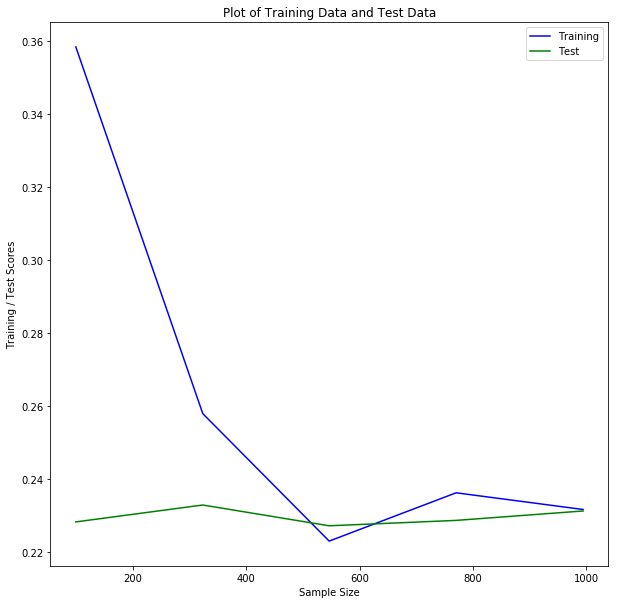

In [76]:
# Plot data and show graph
fig, ax2 = plt.subplots(figsize=(10,10))
ax2.plot(sample_size, train_score.mean(axis=1), color='blue', label='Training')
ax2.plot(sample_size, test_score.mean(axis=1), color='green', label='Test')
plt.legend()

ax2.set_title('Plot of Training Data and Test Data')
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Training / Test Scores')

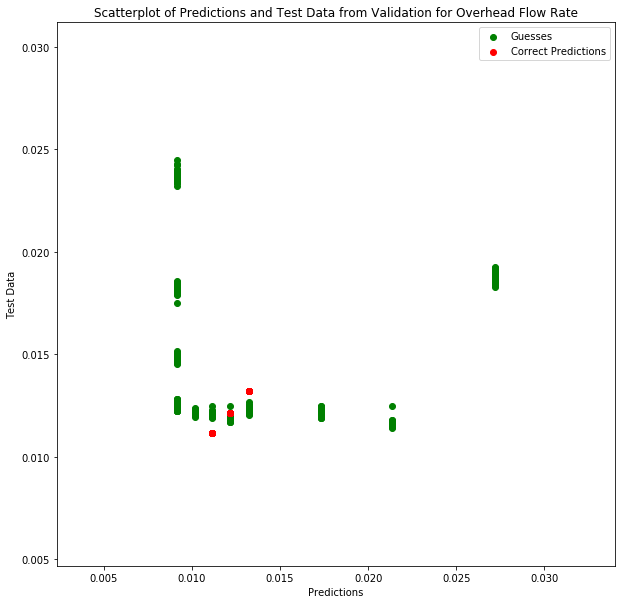

In [77]:
cor_pred = list()

f, ax3 = plt.subplots(figsize=(10,10))
y_test_rows = y_test['Overhead Flow Rate'].values

for i in range(1, len(predictions)):
    if abs(predictions[i] - y_test_rows[i]) < 1e-3:
        cor_pred.append(predictions[i])
        
ax3.scatter(predictions, y_test, color='green', label='Guesses')
ax3.scatter(cor_pred, cor_pred, color='red', label='Correct Predictions')

ax3.set_xlabel('Predictions')
ax3.set_ylabel('Test Data')
ax3.set_title('Scatterplot of Predictions and Test Data from Validation for Overhead Flow Rate')
ax3.legend()

In [78]:
# Check ratio of correct predictions
len(cor_pred)/len(predictions)

0.12474849094567404

------
# Conclusion<a id='#conclusion'>